In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from tqdm import tqdm

from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline
pd.set_option("display.max_rows", 500)

In [3]:
data = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,176207,0,Cash loans,M,Y,N,0,135000.0,450000.0,27193.5,450000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.028663,-18569,-3155,-3017.0,-2042,18.0,1,1,1,1,0,0,Laborers,2.0,2,2,MONDAY,22,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,1.0,-1261.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,PUSH
1,425123,0,Cash loans,F,N,Y,1,193500.0,295668.0,11277.0,193500.0,Unaccompanied,Working,Secondary / secondary special,Separated,House / apartment,0.011703,-16479,-757,-3137.0,-22,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,THURSDAY,12,0,0,0,0,1,1,...,0.0821,0.0924,0.0078,0.0158,block of flats,0.0714,Panel,No,0.0,0.0,0.0,0.0,-84.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,SMS


In [4]:
gp = data[["COMMUNICATION_TYPE", "TARGET"]]
gp_stats = gp.groupby(["COMMUNICATION_TYPE"]).agg({"TARGET": ["count", "mean", "sum"]})
gp_stats.columns = ["OBSERVERS", "EVENTRATE", "EVENTS"]
gp_stats = gp_stats.reset_index()

gp_stats

,COMMUNICATION_TYPE,OBSERVERS,EVENTRATE,EVENTS
0,CALL,3439,0.078802,271
1,IVR,7185,0.067084,482
2,None,3336,0.056055,187
3,PUSH,126096,0.085586,10792
4,SMS,44450,0.071001,3156


## 1. Обучение моделей

In [5]:
numerical_features = data.select_dtypes(exclude=["object"]).columns.tolist() + ["COMMUNICATION_TYPE"]
X, y = data[numerical_features].drop(["SK_ID_CURR", "TARGET"], axis=1), data["TARGET"]

In [6]:
x_train, x_test = train_test_split(
    X, train_size=0.7, random_state=1
)
y_train, y_test = train_test_split(
    y, train_size=0.7, random_state=1
)

In [7]:
def fit_model(X: pd.DataFrame,
              y: pd.Series,
              communication_type: str,
              estimator,
              fillna=-9999
              ):
    """
    Обучение модели под отдельный вид коммуникации.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для обучения модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, поддерживающий API sklearn.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    model: sklearn.callable
        Объект обученной модели.

    """
    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_train = X.drop("COMMUNICATION_TYPE", axis=1)
    x_train, y_train = x_train.loc[mask], y.loc[mask]

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    model = estimator.fit(x_train.fillna(fillna), y_train)

    return model


def evaluate_model(X: pd.DataFrame,
                   y: pd.Series,
                   communication_type: str,
                   estimator,
                   fillna=-9999
                   ) -> float:
    """
    Оценка качества модели с помощью метрики ROC-AUC.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для оценки модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для оценки модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, к которому был применен метод fit.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    score: float
        Значение метрики ROC-AUC.

    """
    check_is_fitted(estimator)

    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_test = X.drop("COMMUNICATION_TYPE", axis=1)
    x_test, y_test = x_test.loc[mask], y.loc[mask]

    y_pred = estimator.predict_proba(x_test.fillna(fillna))
    score = roc_auc_score(y_test, y_pred[:, 1])

    return score

**Строим модель для push-уведомлений:**

In [8]:
models = {}

params = {
    "n_estimators": 250,
    "max_depth": 3,
    "random_state": 27,
    "n_jobs": 6
}

for comm_type in ["PUSH"]:

    model = fit_model(
        X=x_train,
        y=y_train,
        communication_type=comm_type,
        estimator=RandomForestClassifier(**params)
    )
    models[f"{comm_type}_model"] = model

x_train.shape = 88400 rows, 104 cols


In [9]:
# Оценка качества модели

for comm_type in ["PUSH"]:
    model = models[f"{comm_type}_model"]
    score = evaluate_model(
        X=x_test,
        y=y_test,
        communication_type=comm_type,
        estimator=model
    )
    print(f"Communication: {comm_type}, Score: {score}")

Communication: PUSH, Score: 0.712898552813245


## 2. Применение моделей к тестовому набору данных

In [10]:
def create_predictions(models: dict, X: pd.DataFrame, fillna=-9999) -> pd.DataFrame:
    """
    Применение семейства моделей к набору данных X.

    Parameters
    ----------
    models: Dict[estimator]
        Словарь с экземплярами обученных моделей.

    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для применения модели.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    y_pred: pandas.core.frame.DataFrame, shape = [n_samples, len(models)]
        Матрица с прогнозами всех моделей.

    """
    y_pred = pd.DataFrame()
    for model in models:
        estimator = models[model]
        score = estimator.predict_proba(X.fillna(fillna))[:, 1]
        name = model.split("_")[0]
        y_pred[f"{name}_SCORE"] = score

    return y_pred

def calculate_expected_losses(scores: pd.DataFrame, X: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисление матрицы ожидаемых потерь при взаимодействии
    каждым способом. Вычисляется как произведение вероятности
    дефолта на величину платежа.

    Parameters
    ----------
    scores: pandas.core.frame.DataFrame
        Матрица вероятностей дефолта.

    X: pandas.core.frame.DataFrame
        Матрица признаков для применения модели.

    Returns
    -------
    losses: pandas.core.frame.DataFrame
        Матрица ожидаемых потерь.

    """
    scores["SK_ID_CURR"] = X["SK_ID_CURR"]
    scores["AMT_ANNUITY"] = X["AMT_ANNUITY"]
    scores_columns = [col for col in scores.columns if "SCORE" in col]

    for score in scores_columns:
        name = score.split("_")[0]
        name = f"EXPECTED_LOSS_{name}"

        scores[name] = scores["AMT_ANNUITY"] * scores[score]

    return scores

In [11]:
x_test, y_test = test[x_train.columns], test["TARGET"]
x_test = x_test.drop("COMMUNICATION_TYPE", axis=1)

In [12]:
y_pred_test = create_predictions(models, x_test)
y_pred_test = calculate_expected_losses(y_pred_test, test)
y_pred_test = y_pred_test.dropna().reset_index(drop=True)

y_pred_test.head(n=2)

,PUSH_SCORE,SK_ID_CURR,AMT_ANNUITY,EXPECTED_LOSS_PUSH
0,0.063861,174545,31617.0,2019.096191
1,0.087147,209898,25393.5,2212.978169


## Визуализируем данные для понимания распределений

[]

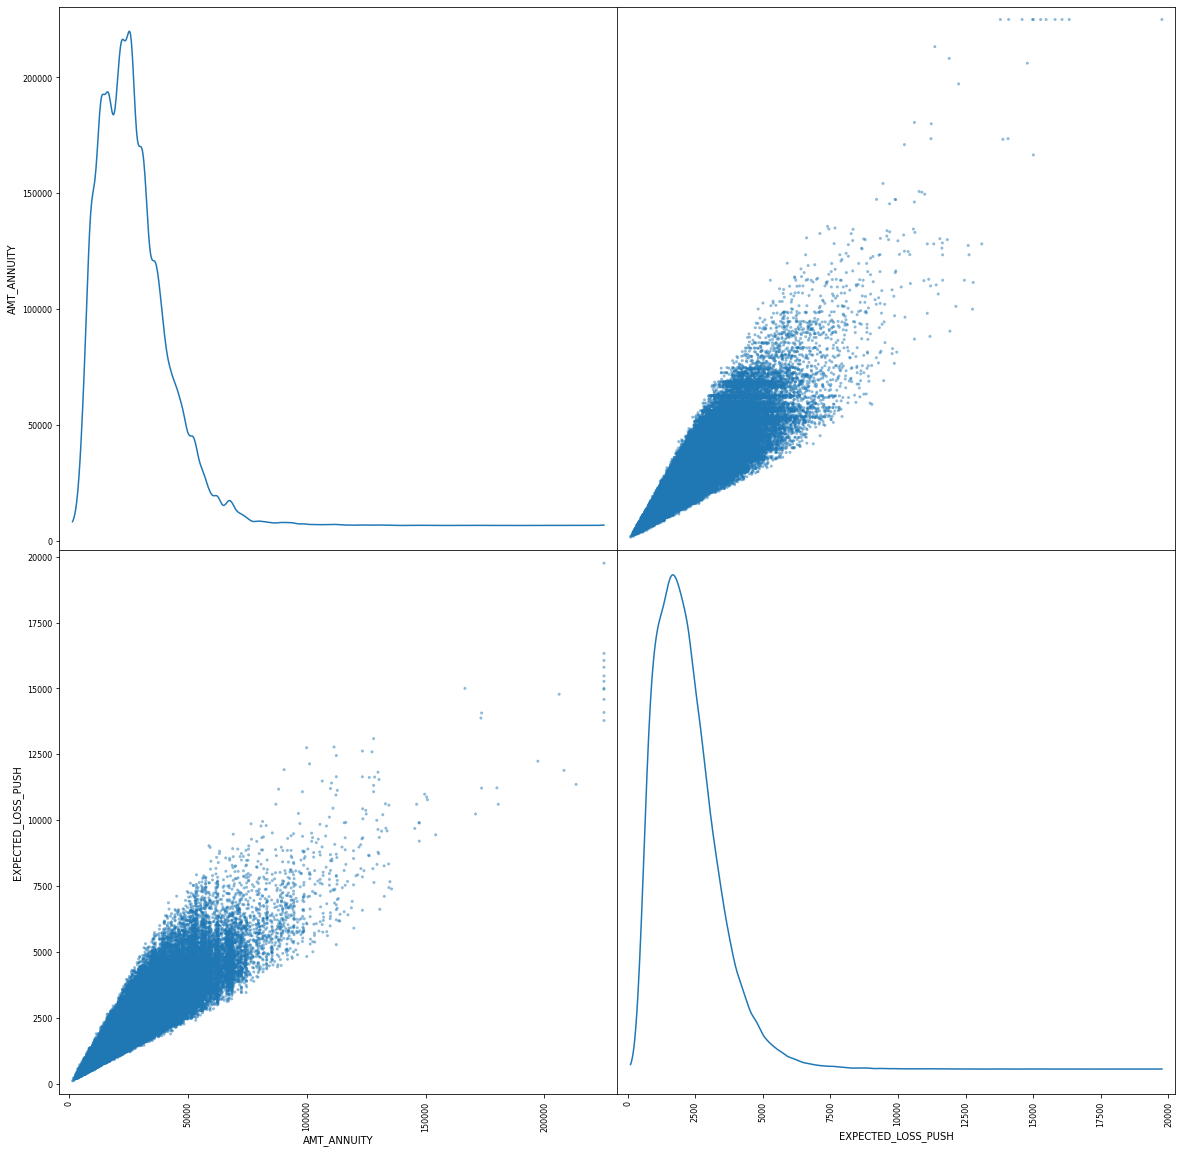

In [13]:
figsize = (20, 20)

cols_to_plot = [
    "AMT_ANNUITY",
    "EXPECTED_LOSS_PUSH"
]

scatter_matrix(
    frame=y_pred_test[cols_to_plot],
    figsize=figsize,
    diagonal="kde"
)
plt.plot()

## 3. Оптимизация типа взаимодействия

In [14]:
stuffdict = {idx: (int(y_pred_test.loc[idx,  "EXPECTED_LOSS_PUSH"]), 1)  for idx in y_pred_test.index}


## 4. Создание списка значений площади и ценности

Разделяем списки значений исходного словаря, например так:

In [15]:
def get_area_and_values(stuffdict: dict):
    area = [value[1] for value in stuffdict.values()]
    value = [value[0] for value in stuffdict.values()]

    return area, value

## 5. Используем списки для мемоизации

In [16]:
def get_memtable(stuffdict, A: int = 200):
    area, value = get_area_and_values(stuffdict)
    n = len(value)

    v = [[0 for a in range(A+1)] for i in range(n+1)]
    for i in tqdm(range(n + 1)):
        for a in range(A + 1):
            if i == 0 or a == 0:
                v[i][a] = 0 # базовый кейс

            elif area[i-1] <= a:
                # если площадь предмета меньше площади столбца
                # то максимизируем значение суммарной ценности
                v[i][a] = max(value[i-1] + v[i-1][a-area[i-1]], v[i-1][a])
    
            else:
                # если площадь предмента больше площади столбца
                # забираем значение ячейки из предыдущей строки
                v[i][a] = v[i-1][a]
    
    return v, area, value

In [17]:
def get_selected_items_list(stuffdict, A=200):
    v, area, value = get_memtable(stuffdict, A)
    n, res = len(value), v[len(value)][A]
    a, items_list = A, []

    for i in range(n, 0, -1):
        if res <= 0:
            break
        if res == v[i-1][a]:
            continue
        else:
            items_list.append((value[i-1], area[i-1]))
            res -= value[i-1]
            a -= area[i-1]
    items_list = set(items_list)

    selected_stuff = []
    for search in items_list:
        for key, value in stuffdict.items():
            if value == search:
                selected_stuff.append(key)

    return selected_stuff

**Пусть есть ограничение A в 1000 push-уведомлений:**

In [18]:
# найденный оптимальный список предметов
stuff = get_selected_items_list(stuffdict, A=1000)


100%|██████████| 123003/123003 [01:07<00:00, 1834.77it/s]


**Выведем соответствующих списку пользователей:**

In [19]:
y_pred_test.loc[stuff, ['SK_ID_CURR', 'EXPECTED_LOSS_PUSH']].head(n=10)

,SK_ID_CURR,EXPECTED_LOSS_PUSH
117610,418059,7072.334935
50964,103342,6494.639102
115578,191158,6494.160130
95307,451306,8542.279952
115419,351885,7528.593322
12172,399580,7505.388647
84778,156804,6274.989337
1340,326070,6126.705599
91256,442998,6126.631267
115623,411092,10603.465342


In [20]:
# проверим суммарную площадь и ценности предметов
total_area = sum([stuffdict[item][0] for item in stuff])
total_value = sum([stuffdict[item][1] for item in stuff])

print(f"total_area = {total_area}")
print(f"total_value = {total_value}")

total_area = 7431337
total_value = 1002


In [21]:
# визуализация результат оптимизации
def plot_memtable(V, stuffdict):
    plt.figure(figsize=(30,15))
#   item_list = list(stuffdict.keys())
#   item_list.insert(0, -1)
    sns.heatmap(V)
#   plt.yticks(item_list)
    plt.xlabel('Area', size=25)
    plt.ylabel('Added item', size=25)
    plt.title('Value for Area with Set of Items', size=30)
    plt.show()

In [22]:
v, area, value = get_memtable(stuffdict)
# plot_memtable(v, stuffdict)

100%|██████████| 123003/123003 [00:13<00:00, 9416.05it/s]


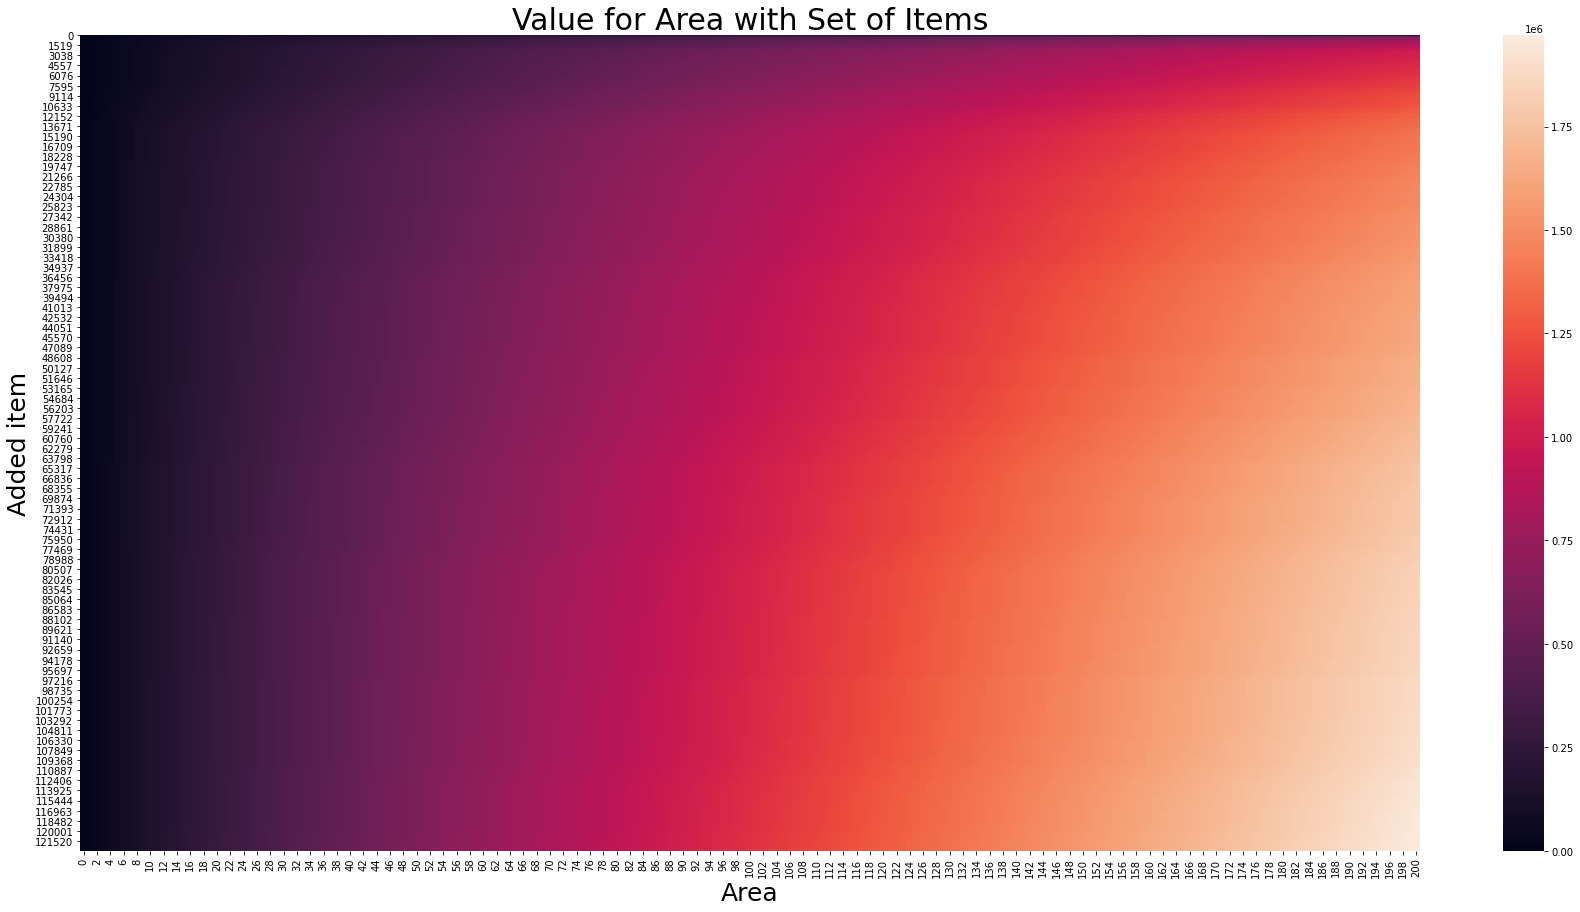

In [23]:
plot_memtable(v, stuffdict)